In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from gap.models.score_sde import GScoreModel3D, ScoreModel3D
from gap.load import get_data_loader
from gap.utils import get_default_device
from gap.purify import purify
from gap.geometry import distance_to_manifold
from gap.train import train_score_model

In [3]:
device = get_default_device()
print(f"Running on {device}")

Running on cpu


In [4]:
train_loader = get_data_loader("swiss_roll", batch_size=128, train=True)

In [21]:
model = GScoreModel3D().to(device)
model = ScoreModel3D().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [22]:
trained_model, ema = train_score_model(
    model=model,
    dataloader=train_loader,
    optimizer=optimizer,
    device=device,
    epochs=100,
    log_interval=50
)

Training on cpu for 100 epochs...
Epoch 50/100 | Average Loss: 2.6183
Epoch 100/100 | Average Loss: 2.4163
Training complete.


In [23]:
ema.apply_shadow(model)

In [16]:
test_loader = get_data_loader("swiss_roll", batch_size=128, train=False)

batch_data, batch_targets = next(iter(test_loader))

clean_idx = torch.randint(0, batch_data.shape[0], (1,))
clean_point = batch_data[clean_idx]

perturbation = torch.tensor([0.5, 0.5, 0.5])
x_adv = clean_point + perturbation

print(f"Clean Point: {clean_point.cpu().numpy()}")
print(f"Adversarial Point: {x_adv.cpu().numpy()}")

Clean Point: [[ 0.9598227  -0.10402746  1.5420378 ]]
Adversarial Point: [[1.4598227  0.39597255 2.042038  ]]


Run Purification

In [24]:
sigmas_simple = torch.tensor([0.01], device=device)
trajectory_simple = purify(x_adv, model, sigmas_simple, device=device, steps_per_sigma=50, lr=0.02, simple=True)

In [25]:
sigmas_annealed = torch.exp(torch.linspace(np.log(5.0), np.log(0.01), 20)) # Start at sigma=2.0 (very noisy)
trajectory_annealed = purify(x_adv, model, sigmas_annealed, device=device, steps_per_sigma=50, lr=0.02, simple=False)

In [ ]:
train_tensor = torch.cat([batch[0] for batch in train_loader], dim=0)

p_simple = torch.from_numpy(trajectory_simple[-1]).view(1, -1)
p_annealed = torch.from_numpy(trajectory_annealed[-1]).view(1, -1)

x_adv_cpu = x_adv.cpu()

adv_dist, closest_to_adv = distance_to_manifold(x_adv_cpu, train_tensor)
pure_dist_simple, closest_to_pure_simple = distance_to_manifold(p_simple, train_tensor)
pure_dist_annealed, closest_to_pure_annealed = distance_to_manifold(p_annealed, train_tensor)

print("--- Purification Results ---")
print(f"Initial Attack Distance: {adv_dist:.4f}")
print(f"Simple Method Error:     {pure_dist_simple:.4f} ({adv_dist/pure_dist_simple:.1f}x improvement)")
print(f"Annealed Method Error:   {pure_dist_annealed:.4f} ({adv_dist/pure_dist_annealed:.1f}x improvement)")

--- Purification Results ---
Initial Attack Distance: 0.7216
Simple Method Error:     0.7172 (1.0x improvement)
Annealed Method Error:   0.0784 (9.2x improvement)


In [27]:
import plotly.graph_objects as go
import numpy as np
import torch

# --- SMALL MODS: Device & Type Handling ---
# 1. Ensure tensors are on CPU before converting to numpy
manifold_np = train_tensor.cpu().numpy()
clean_np = clean_point.cpu().numpy().reshape(-1) # Flatten to [3]
adv_np = x_adv.cpu().numpy().reshape(-1)       # Flatten to [3]

# 2. Trajectories are already numpy from our purify module
traj_simple_np = trajectory_simple
traj_annealed_np = trajectory_annealed

# 3. Endpoints (already numpy)
# If trajectory is [Steps, Batch, 3], we take [:, 0, :] to get the first point's path
if traj_simple_np.ndim == 3:
    traj_simple_np = traj_simple_np[:, 0, :]
    traj_annealed_np = traj_annealed_np[:, 0, :]

pure_simple_np = traj_simple_np[-1]
pure_annealed_np = traj_annealed_np[-1]

# 4. Nearest neighbors (ensure these are CPU tensors first)
closest_pure_simple_np = closest_to_pure_simple.cpu().numpy().reshape(-1)
closest_pure_annealed_np = closest_to_pure_annealed.cpu().numpy().reshape(-1)
closest_to_adv_np = closest_to_adv.cpu().numpy().reshape(-1)

# --- REST OF SCRIPT REMAINS THE SAME ---
fig = go.Figure()

# 1. The Manifold (Swiss Roll)
fig.add_trace(go.Scatter3d(
    x=manifold_np[:, 0], y=manifold_np[:, 1], z=manifold_np[:, 2],
    mode='markers',
    marker=dict(size=1.5, color=manifold_np[:,1], colorscale='Viridis', opacity=0.6),
    name='Swiss Roll Manifold'
))

# 2. Simple Purification Path
fig.add_trace(go.Scatter3d(
    x=traj_simple_np[:, 0], y=traj_simple_np[:, 1], z=traj_simple_np[:, 2],
    mode='lines',
    line=dict(color='orange', width=3),
    name='Simple Path (Fixed Sigma)'
))

# 3. Annealed Purification Path
fig.add_trace(go.Scatter3d(
    x=traj_annealed_np[:, 0], y=traj_annealed_np[:, 1], z=traj_annealed_np[:, 2],
    mode='lines',
    line=dict(color='blue', width=5),
    name='Annealed Path (Diffusion)'
))

# 4. Key Markers
fig.add_trace(go.Scatter3d(
    x=[clean_np[0]], y=[clean_np[1]], z=[clean_np[2]],
    mode='markers', marker=dict(size=10, color='green'), name='Original Clean'
))
fig.add_trace(go.Scatter3d(
    x=[adv_np[0]], y=[adv_np[1]], z=[adv_np[2]],
    mode='markers', marker=dict(size=10, color='red', symbol='x'), name='Adversarial Input'
))
fig.add_trace(go.Scatter3d(
    x=[pure_simple_np[0]], y=[pure_simple_np[1]], z=[pure_simple_np[2]],
    mode='markers', marker=dict(size=8, color='orange', symbol='diamond'), name='Simple Result'
))
fig.add_trace(go.Scatter3d(
    x=[pure_annealed_np[0]], y=[pure_annealed_np[1]], z=[pure_annealed_np[2]],
    mode='markers', marker=dict(size=8, color='blue', symbol='circle'), name='Annealed Result'
))

# 5. Distance Metrics (Error Lines)
fig.add_trace(go.Scatter3d(
    x=[adv_np[0], closest_to_adv_np[0]], y=[adv_np[1], closest_to_adv_np[1]], z=[adv_np[2], closest_to_adv_np[2]],
    mode='lines', line=dict(color='red', width=2, dash='dot'),
    name=f'Initial Attack Dist: {adv_dist:.2f}'
))

fig.add_trace(go.Scatter3d(
    x=[pure_simple_np[0], closest_pure_simple_np[0]], 
    y=[pure_simple_np[1], closest_pure_simple_np[1]], 
    z=[pure_simple_np[2], closest_pure_simple_np[2]],
    mode='lines', line=dict(color='orange', width=2, dash='dash'),
    name=f'Simple Final Error: {pure_dist_simple:.2f}'
))

fig.add_trace(go.Scatter3d(
    x=[pure_annealed_np[0], closest_pure_annealed_np[0]], 
    y=[pure_annealed_np[1], closest_pure_annealed_np[1]], 
    z=[pure_annealed_np[2], closest_pure_annealed_np[2]],
    mode='lines', line=dict(color='blue', width=2, dash='dash'),
    name=f'Annealed Final Error: {pure_dist_annealed:.2f}'
))

fig.update_layout(
    title="Comparison: Simple vs. Annealed Purification",
    scene=dict(aspectmode='data'),
    width=1000, height=800
)

fig.show()

<>:36: SyntaxWarning:

invalid escape sequence '\s'

<>:36: SyntaxWarning:

invalid escape sequence '\s'

/var/folders/tb/dj89jjf13cd8hrrvfh09h7sr0000gn/T/ipykernel_82508/3213381735.py:36: SyntaxWarning:

invalid escape sequence '\s'



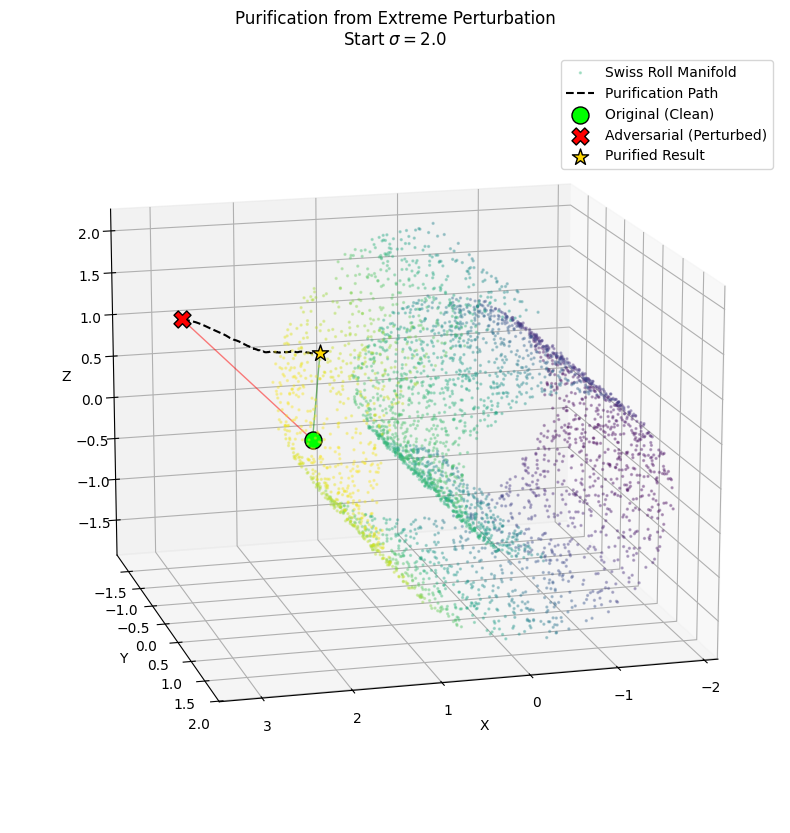

In [56]:
# Visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection="3d")

# --- BETTER MANIFOLD VISUALIZATION ---
# Instead of random scatter, we sort the points by the 1st dimension (the spiral)
# to make it look more like a connected surface.
d = train_tensor.numpy()
# Filter points to just show the "spine" of the roll for clarity
ax.scatter(d[:, 0], d[:, 1], d[:, 2], c=d[:, 0], cmap='viridis', s=2, alpha=0.3, label="Swiss Roll Manifold")

# --- PLOT THE JOURNEY ---
# Trajectory: Blue line with markers
ax.plot(trajectory_annealed[:, 0], trajectory_annealed[:, 1], trajectory_annealed[:, 2], 
        color='black', linewidth=1.5, linestyle='--', label="Purification Path")

# Start (Green) -> Attack (Red) -> End (Gold)
ax.scatter(clean_point[:, 0], clean_point[:, 1], clean_point[:, 2], 
           color='lime', s=150, edgecolors='black', label="Original (Clean)")
ax.scatter(x_adv[:, 0], x_adv[:, 1], x_adv[:, 2], 
           color='red', s=150, marker='X', edgecolors='black', label="Adversarial (Perturbed)")
ax.scatter(trajectory_annealed[-1, 0], trajectory_annealed[-1, 1], trajectory_annealed[-1, 2], 
           color='gold', s=150, marker='*', edgecolors='black', label="Purified Result")

# --- DRAW CONNECTOR LINES ---
# Draw a thin red line from Clean -> Adversarial (The "Attack")
ax.plot([clean_point[0,0], x_adv[0,0]], 
        [clean_point[0,1], x_adv[0,1]], 
        [clean_point[0,2], x_adv[0,2]], color='red', alpha=0.5, linewidth=1)

# Draw a thin green line from Purified -> Clean (The "Error")
ax.plot([trajectory_annealed[-1,0], clean_point[0,0]], 
        [trajectory_annealed[-1,1], clean_point[0,1]], 
        [trajectory_annealed[-1,2], clean_point[0,2]], color='green', alpha=0.5, linewidth=1)

ax.set_title(f"Purification from Extreme Perturbation\nStart $\sigma=2.0$")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()

# Set a better view angle to see the 'gap' in the roll
ax.view_init(elev=15, azim=75)

plt.show()